Міністерство освіти і науки України 

Національний технічний університет України «КПІ ім. Ігоря Сікорського»

Факультет інформатики та обчислювальної техніки

Кафедра інформатики та програмної інженерії

Аналіз даних в інформаційно-управляючих системах

Виконанав студент:

ІП-01 Хернуф Валід Алі-Еддін

Київ 2022


---

# **Звіт до лабораторної роботи №5**

## **Основне завдання**

Спочатку імпортуємо усі потрібні бібліотеки для праці: matplotlib.pyplot, scipy.stats, pandas, numpy та деяки дяки методи з бібліотеки sklearn.

In [1]:
import matplotlib.pyplot as pyp
import scipy.stats as st
import pandas as p
import numpy as n
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Завантажимо дані із файлу winequality-red.csv:

In [2]:
def read_dataset(path, separ, en):
    return p.read_csv(path, sep = separ, encoding = en)

dFrame = read_dataset("winequality-red.csv", ',', 'cp1252')

### 1. Дослідження даних та їх підготовка для побудови регресійної моделі

In [3]:
dFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Всі значення мають коректний тип даних та мають однакову кілкість, тобто пустих значень немає. Для підтвердження зробимо перевірку на негативні та порожні значення:

In [4]:
print(f"Is there any nan: {dFrame.isnull().values.any()}")

print(f"Is there any negative: {(dFrame < 0).values.any()}")

Is there any nan: False
Is there any negative: False


Після підтверждення що всі значення ненульові та позитивні, перевіримо чи нормально розподілені стовпці за допомогою тестів Комлагорова-Смірнова та Пірсона:

In [5]:
def kolm_smirn_check(dFrame, column):
    ks_statistic, p_value = st.kstest(dFrame[column], 'norm')
    if p_value > 0.05: return True
    return False

def pearson_check(dFrame, column):
    statistic, p_value = st.normaltest(dFrame[column])
    if p_value > 0.05: return True
    return False

print("#1 test - Kolmagorov-Smirnov test,\n#2 test - Pearson test\n")
for c in dFrame.columns:
    print('{0:<23}'.format(c + ":"),f"#1 test - {kolm_smirn_check(dFrame, c)}, #2 test - {pearson_check(dFrame, c)};")

#1 test - Kolmagorov-Smirnov test,
#2 test - Pearson test

fixed acidity:          #1 test - False, #2 test - False;
volatile acidity:       #1 test - False, #2 test - False;
citric acid:            #1 test - False, #2 test - False;
residual sugar:         #1 test - False, #2 test - False;
chlorides:              #1 test - False, #2 test - False;
free sulfur dioxide:    #1 test - False, #2 test - False;
total sulfur dioxide:   #1 test - False, #2 test - False;
density:                #1 test - False, #2 test - False;
pH:                     #1 test - False, #2 test - False;
sulphates:              #1 test - False, #2 test - False;
alcohol:                #1 test - False, #2 test - False;
quality:                #1 test - False, #2 test - False;


Жодний з стовпців розподілен нормально. Подивимось на матрицю корреляцій:

In [6]:
dFrame.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


### 2. Розділення даних на навчальну та тестову вибірки

In [7]:
first = dFrame.iloc[:, :11]
second = dFrame['quality']
f_train, f_test, s_train, s_test = train_test_split(first, second, test_size=0.33, random_state = 10)

### 3. Побудова декількьох регресійних моделей для прогнозу якості вина

In [8]:
r_models = [LinearRegression().fit(f_train, s_train)]
for i in range(2, 5):
    r_models.append(make_pipeline(PolynomialFeatures(degree=i) , LinearRegression()))
    r_models[i - 1].fit(f_train, s_train)

### 4. З'ясування яка з моделей краща

In [9]:
mse = []
r_2 = []
for r_model in r_models:
    predict = r_model.predict(f_test)
    mse.append(mean_squared_error(s_test, predict))
    r_2.append(r2_score(s_test, predict))

Знайдемо накращу модель за допомогою RSE та коефіцієнтом R^2:

In [10]:
rse_s = []
r_2_s = []

for r_model in r_models:
    rse_s.append(((n.sum(n.square(s_test - r_model.predict(f_test))))/(len(s_test) - 2)) ** 0.5)
    r_2_s.append(r2_score(s_test, r_model.predict(f_test)))
print('Best rse index: ', n.argmin(rse_s) + 1)
print('Best r_2 index: ', n.argmax(r_2_s) + 1)

Best rse index:  1
Best r_2 index:  1


Бачимо, що накрайщою моделлю є лінійна.

## **Додаткове завдання**

Завантажимо дані із Data4.csv, змінимо назву першого стовпчика та змінимо тип данних деяких стовпців:

In [11]:
def set_column_type_float(dFrame, column):
    dFrame[column] = dFrame[column].str.replace(',', '.').astype(float)

def data_fix(dFrame):
    dFrame.columns.values[0] = "Country"
    for i in range(3,7):
        set_column_type_float(dFrame, dFrame.columns[i])
    return dFrame

dFrame = read_dataset("Data4.csv", ';', 'cp1251')
dFrame = data_fix(dFrame)
dFrame.info()
dFrame.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  132 non-null    object 
 1   ISO      132 non-null    object 
 2   UA       132 non-null    object 
 3   Cql      132 non-null    float64
 4   Ie       132 non-null    float64
 5   Iec      132 non-null    float64
 6   Is       132 non-null    float64
dtypes: float64(4), object(3)
memory usage: 5.7+ KB


,Country,ISO,UA,Cql,Ie,Iec,Is
0,Albania,ALB,Албанія,0.973924,0.605348,0.538673,0.510113
1,Algeria,DZA,Алжир,0.782134,0.587219,0.348159,0.497986
2,Angola,AGO,Ангола,0.372344,0.274394,0.332117,0.346907
3,Argentina,ARG,Аргентина,0.883830,0.699685,0.281995,0.518820
4,Armenia,ARM,Вірменія,1.016499,0.718327,0.535648,0.486498


### 1. Дослідження даних, визначення чи є мультиколінеарність, побудування діаграми розсіювання

Подивимось на матрицю кореляцій для з'ясування мультиколінеарності параметрів:

In [12]:
dFrame.corr()

,Cql,Ie,Iec,Is
Cql,1.000000,0.883664,0.875545,0.939172
Ie,0.883664,1.000000,0.619247,0.746320
Iec,0.875545,0.619247,1.000000,0.799211
Is,0.939172,0.746320,0.799211,1.000000


Майже всі параматри є мультиколінеарними. Тепер побудуэмо діаграми розсіювання:

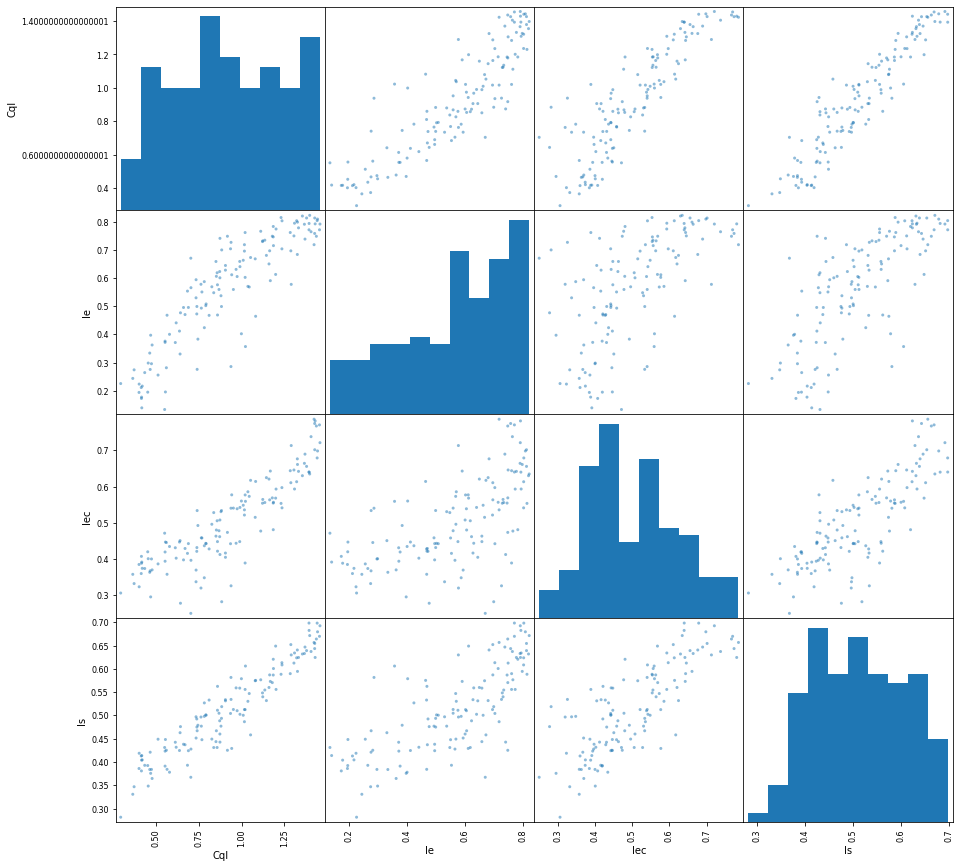

In [13]:
p.plotting.scatter_matrix(dFrame, figsize=(15, 15))
pyp.show()

### 2. Побудування декількох регресійних моделей

Побудуємо лінійні та поліноміальні моделі другого порядку для всіх можливих комбінації параметрів:

In [14]:
Y = dFrame['Cql']

par = ["Ie", "Is", "Iec", ["Ie", "Is"], ["Ie", "Iec"], ["Is", "Iec"], ["Ie", "Is", "Iec"]]

lin = []
pol = []
for i in range(len(par)):
    pol.append(make_pipeline(PolynomialFeatures(degree = 2), LinearRegression()))
    if i < 3: 
        lin.append(LinearRegression().fit(dFrame[par[i]].to_numpy().reshape(-1, 1), Y))
        pol[i].fit(dFrame[par[i]].to_numpy().reshape(-1, 1), Y)
    else :
        lin.append(LinearRegression().fit(dFrame[par[i]], Y))
        pol[i].fit(dFrame[par[i]], Y)

### 3. З'ясування яка з моделей краща

Завантажимо тестові дані із Data4t.csv та відкорегуємо їх так само, як й основні дані:

In [15]:
dFrame_t = read_dataset("Data4t.csv", ";", "cp1251")
dFrame_t = data_fix(dFrame_t)

dFrame_t.info()
dFrame_t.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  5 non-null      object 
 1   ISO      5 non-null      object 
 2   UA       5 non-null      object 
 3   Cql      5 non-null      float64
 4   Ie       5 non-null      float64
 5   Iec      5 non-null      float64
 6   Is       5 non-null      float64
dtypes: float64(4), object(3)
memory usage: 284.0+ bytes


,Country,ISO,UA,Cql,Ie,Iec,Is
0,Togo,TGO,Того,0.453498,0.216806,0.368235,0.433951
1,Tunisia,TUN,Туніс,0.899462,0.659124,0.418256,0.514746
2,Turkey,TUR,Туреччина,0.859284,0.498840,0.509228,0.499453
3,Uganda,UGA,Уґанда,0.571284,0.362946,0.448732,0.375726
4,Ukraine,UKR,Україна,0.802204,0.689164,0.303555,0.462744


Підрахуємо передбачувані дані для лінійних та поліноміальних моделей:

In [16]:
prediction = []

def predict_by(prediction, s):
    for i in range(len(par)):
        if i < 3:
            prediction.append(s[i].predict(dFrame_t[par[i]].to_numpy().reshape(-1, 1)))
        else:
            prediction.append(s[i].predict(dFrame_t[par[i]]))
    return prediction

prediction = predict_by(prediction, lin)
prediction = predict_by(prediction, pol)

Знайдемо найкращу модель:

In [17]:
min_i = n.sum((n.array(prediction)- dFrame_t['Cql'].to_numpy())**2,axis = 1).argmin()

print("Best model is:")
if (min_i < 6):
    print(f"linear model by {par[min_i]} params")
else:
    print(f"polynomial model by {par[min_i - 7]} params")

Best model is:
polynomial model by ['Ie', 'Is', 'Iec'] params


Як ми бачимо, найкращою моделлю є поліноміальна модель другого степеня з трьома змінними.